# Self-Driving Car Nanodegree
## Project 4: Advanced Lane Finding

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from math import atan2, hypot # angle and dist
import os
%matplotlib inline
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Reading Image

In [10]:
#reading in an image
images=[]
for fn in os.listdir("test_images/"):
    print('Image File:', fn)
    image = mpimg.imread('test_images/'+fn)
    images.append(image)
    #plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imsh
    #plt.show()

Image File: test3.jpg
Image File: test1.jpg
Image File: test5.jpg
Image File: straight_lines2.jpg
Image File: test4.jpg
Image File: test2.jpg
Image File: test6.jpg
Image File: straight_lines1.jpg


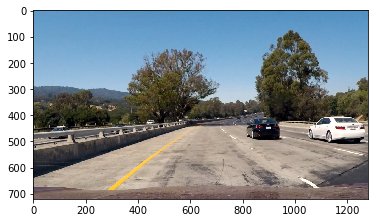

In [11]:
plt.imshow(images[1])

# Pipe line modules

## 1. Camera Undistort

In [66]:
import pickle

dist_pickle = pickle.load(open("./cam_calib.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def CamUndistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

## 2. Color and gradient thresholding

In [67]:
def Thresholding(img, s_thresh=(170, 255), h_thresh=(42, 80), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:, :, 0]
    l_channel = hsv[:, :, 1]
    s_channel = hsv[:, :, 2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold color channel
    #l_binary = np.zeros_like(l_channel)
    #l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((sxbinary, s_binary, h_binary))
    
    #merge =np.logical_or( 
    #        np.logical_or(sxbinary, s_binary), 
    #        np.logical_and(h_binary, l_binary))
    
    return color_binary

## 3. Region of Interest

In [68]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def ROI(img):
    imshape = img.shape
    horizon_x1, horizon_x2 = 629, 680
    horizon_y = 419
    vertices = np.array([[(0,imshape[0]),(horizon_x1, horizon_y), (horizon_x2, horizon_y), 
                          (imshape[1],imshape[0])]], dtype=np.int32)
    return region_of_interest(img, vertices)

## 4. Perspect Transform

# Put together the Pipeline

In [86]:
def Pipeline(image):
    out = CamUndistort(image)    
    out = Thresholding(out)
    out = ROI(out)
    out = PerspectiveTransform(out)
    #S3 = LaneTracking(S2)
    #Curv = MeasureCurvature(S3)
    #S4 = LaneVisualization(S3)
    return out

In [151]:
def PerspectiveTransform(img):    
    y, x = img.shape[0], img.shape[1]    
    #hx1, hx2 = 510, 780    
    #hy = 480
    hx1, hx2 = 547, 738
    hy = 461
    offset = 200
    src = np.float32([[hx1, hy], [hx2, hy], [0, y-1], [x-1, y-1]])    
    dst = np.float32([[offset, 0], [x-1-offset, 0], [offset, y-1], [x-1-offset, y-1]])    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (x, y), flags=cv2.INTER_LINEAR)
    return warped

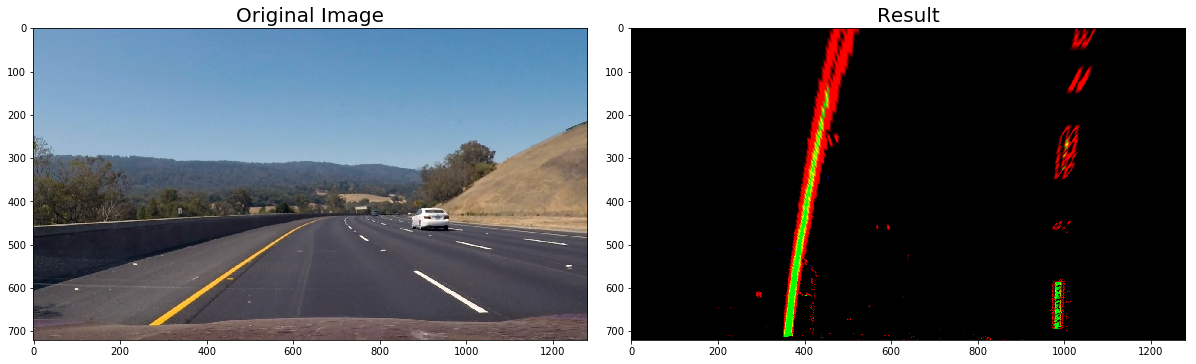

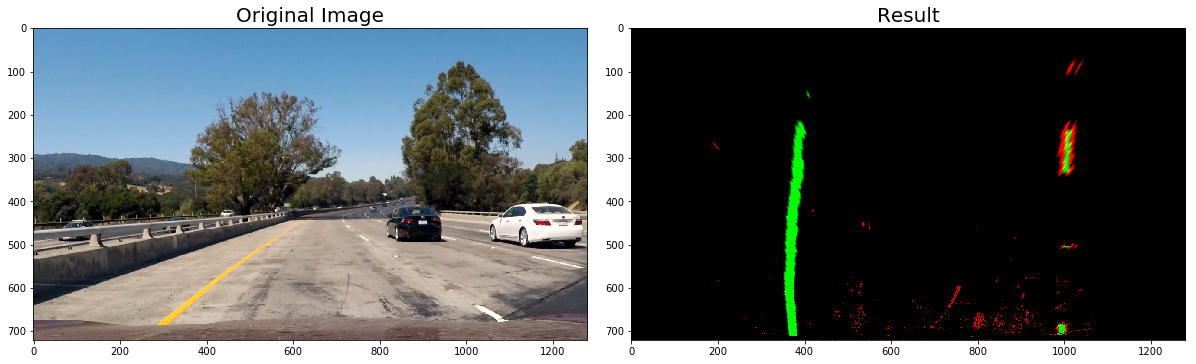

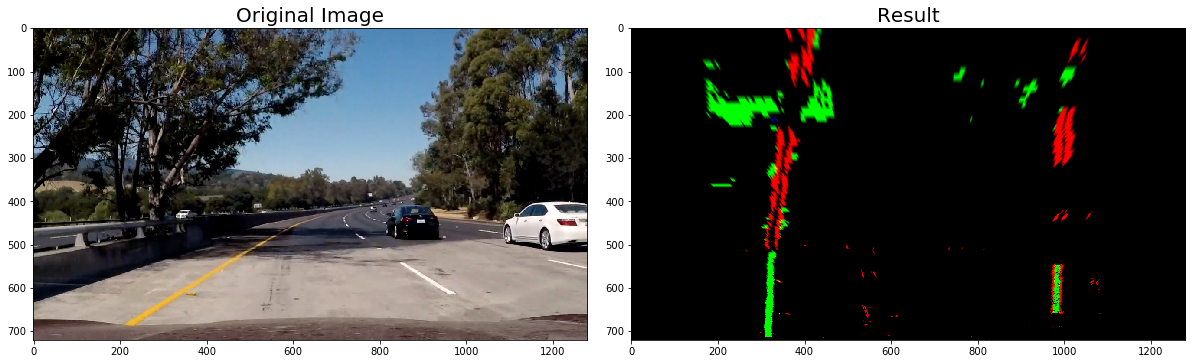

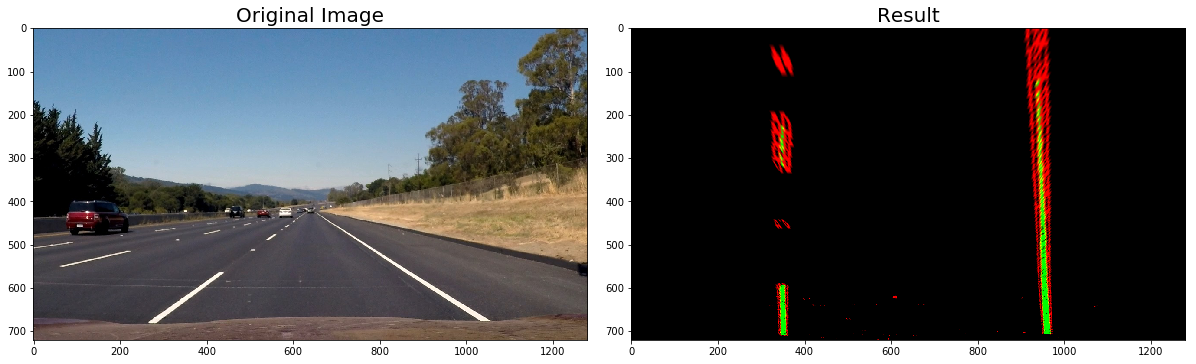

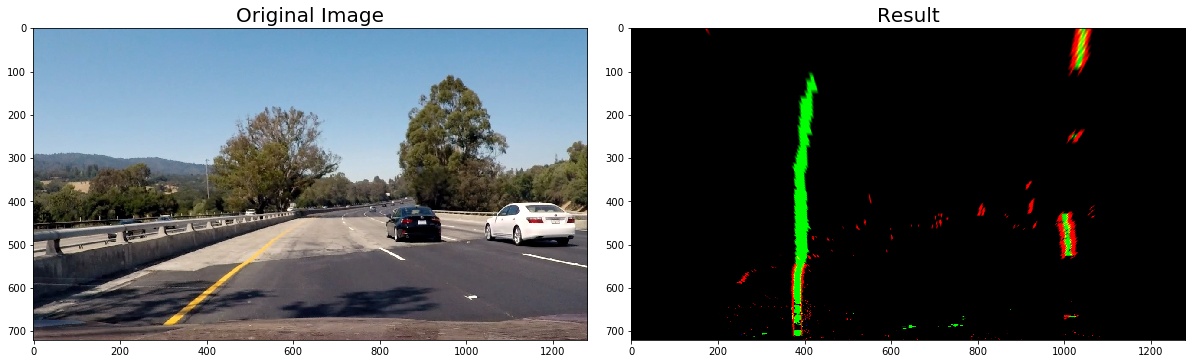

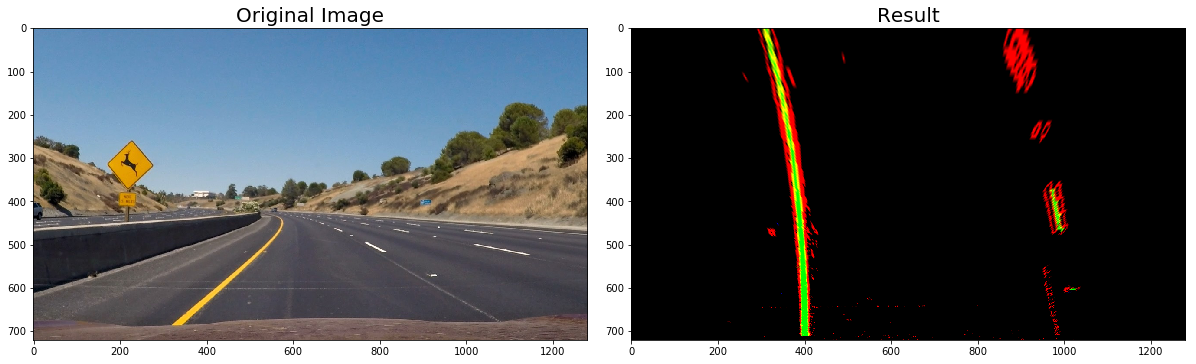

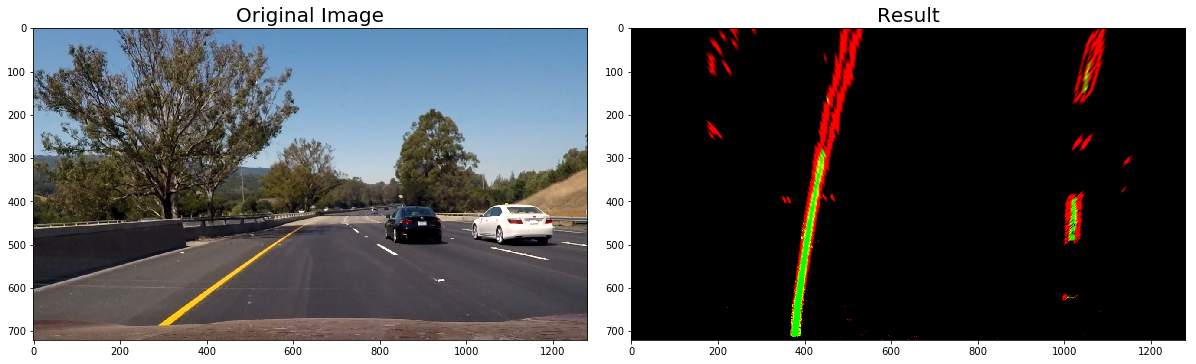

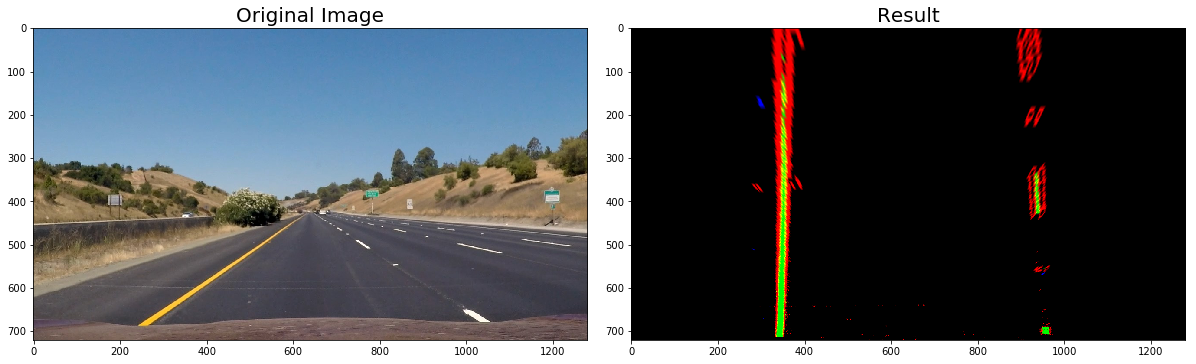

In [152]:
for image in images:
    result = Pipeline(image)
    #result = PerspectiveTransform(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(result)
    ax2.set_title('Result', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()